# Training
This notebook trains the model with 3 fold cross validation.

In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 06:51:43] [setup] RAM Tracking...
[codecarbon INFO @ 06:51:43] [setup] GPU Tracking...
[codecarbon INFO @ 06:51:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 06:51:43] [setup] CPU Tracking...
[codecarbon WARNING @ 06:51:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 06:51:46] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 06:51:46] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 06:51:46] >>> Tracker's metadata:
[codecarbon INFO @ 06:51:46]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 06:51:46]   Python version: 3.11.3
[codecarbon INFO @ 06:51:46]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 06:51:46]   Available RAM : 256.000 GB
[codecarbon INFO @ 06:51:46]   CPU count: 24
[codecarbon INFO @ 06:51:46]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

[codecarbon WARNING @ 08:55:41] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.


[codecarbon INFO @ 08:55:41] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor


[codecarbon INFO @ 08:55:41] >>> Tracker's metadata:


[codecarbon INFO @ 08:55:41]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34


[codecarbon INFO @ 08:55:41]   Python version: 3.11.3


[codecarbon INFO @ 08:55:41]   CodeCarbon version: 2.3.4


[codecarbon INFO @ 08:55:41]   Available RAM : 256.000 GB


[codecarbon INFO @ 08:55:41]   CPU count: 24


[codecarbon INFO @ 08:55:41]   CPU model: AMD EPYC 7642 48-Core Processor


[codecarbon INFO @ 08:55:41]   GPU count: 1


[codecarbon INFO @ 08:55:41]   GPU model: 1 x NVIDIA A100-PCIE-40GB


In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

# Imports and setup

In [3]:
import sys
# Need this to load the packages correct in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = "18gqn5gdnlbv"
print(HASH_NAME)

18gqn5gdnlbv


In [8]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
priority_df = pd.read_csv(f"{path_to_files}/{file_name}")
priority_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
# Check if NaN
priority_df.isna().any()

label    False
text     False
dtype: bool

In [13]:
priority_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [14]:
priority_df["label"].value_counts()

label
0    21315
1    21315
Name: count, dtype: int64

In [15]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [16]:
df = train_hp_df
df

,label,text
1557,0,use correct case for help documentation in eg ...
18010,0,overwriting bookmark folders when syncing devi...
33337,0,no results if country is specified in the quer...
18424,0,prepopulate subject of message when clicking r...
2982,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
5580,0,railsport doesnt validate html in diary entrie...
31416,0,creation time wrong tz issue description api c...
35919,1,fix view name field not displaying in analytic...
31099,0,report more pwa bugs we currently only report ...


In [17]:
df.reset_index(inplace = True)
df = df.drop('index', axis=1)
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
36230,0,railsport doesnt validate html in diary entrie...
36231,0,creation time wrong tz issue description api c...
36232,1,fix view name field not displaying in analytic...
36233,0,report more pwa bugs we currently only report ...


In [61]:
df["label"].value_counts()

label
0    18128
1    18107
Name: count, dtype: int64

In [18]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [19]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      0        6043
       1        6036
1      0        6045
       1        6033
2      0        6040
       1        6038
Name: count, dtype: int64

In [20]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,2
1,0,overwriting bookmark folders when syncing devi...,2
2,0,no results if country is specified in the quer...,1
3,0,prepopulate subject of message when clicking r...,2
4,0,timeout on wiki listoffeaturedimages does not ...,1
...,...,...,...
36230,0,railsport doesnt validate html in diary entrie...,2
36231,0,creation time wrong tz issue description api c...,0
36232,1,fix view name field not displaying in analytic...,1
36233,0,report more pwa bugs we currently only report ...,1


In [21]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [22]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [23]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [24]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [25]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [26]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [28]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [30]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [31]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [32]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

<h2> Testing Inference </h2>


In [33]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [34]:
test_df = test_hp_df

In [35]:
test_df

,label,text
11991,1,github oauth requesttoken flow is broken in al...
32353,1,track view sequence does not autostart in game...
25650,0,many rule have string argument when they shoul...
2607,0,undeploy issues with an app deployed to a stop...
2429,0,miniroundabouts show up at zoom even if none o...
...,...,...
6265,1,help with locality i have some data that inclu...
11284,1,add support for http forwarded headers engine ...
38158,1,enhance twg https restriction to be based on h...
860,0,after update to jsf web app causes server shut...


In [62]:
test_df["label"].value_counts()

label
1    3208
0    3187
Name: count, dtype: int64

In [36]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [37]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [38]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [39]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [40]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 400/400 [02:19<00:00,  2.88it/s]


Fold 1


100%|██████████| 400/400 [02:47<00:00,  2.39it/s]


Fold 2


100%|██████████| 400/400 [02:46<00:00,  2.40it/s]


  6%|███████▎                                                                                                        | 26/400 [00:04<00:56,  6.60it/s]

  7%|███████▌                                                                                                        | 27/400 [00:04<00:54,  6.90it/s]

  7%|███████▊                                                                                                        | 28/400 [00:04<00:52,  7.13it/s]

  7%|████████                                                                                                        | 29/400 [00:04<00:56,  6.55it/s]

  8%|████████▍                                                                                                       | 30/400 [00:05<00:57,  6.38it/s]

  8%|████████▋                                                                                                       | 31/400 [00:05<00:58,  6.31it/s]

  8%|████████▉                                                                                                       | 32/400 [00:05<01:00,  6.06it/s]

  8%|█████████▏                                                                                                      | 33/400 [00:05<01:02,  5.88it/s]

  8%|█████████▌                                                                                                      | 34/400 [00:05<00:55,  6.65it/s]

  9%|█████████▊                                                                                                      | 35/400 [00:05<00:56,  6.41it/s]

  9%|██████████                                                                                                      | 36/400 [00:06<00:57,  6.38it/s]

  9%|██████████▎                                                                                                     | 37/400 [00:06<00:53,  6.73it/s]

 10%|██████████▉                                                                                                     | 39/400 [00:06<00:51,  7.06it/s]

 10%|███████████▏                                                                                                    | 40/400 [00:06<00:54,  6.61it/s]

 10%|███████████▍                                                                                                    | 41/400 [00:06<00:54,  6.56it/s]

 10%|███████████▊                                                                                                    | 42/400 [00:07<00:57,  6.23it/s]

 11%|████████████                                                                                                    | 43/400 [00:07<00:59,  6.02it/s]

 11%|████████████▎                                                                                                   | 44/400 [00:07<00:56,  6.27it/s]

 11%|████████████▌                                                                                                   | 45/400 [00:07<00:58,  6.03it/s]

 12%|████████████▉                                                                                                   | 46/400 [00:07<01:00,  5.86it/s]

 12%|█████████████▏                                                                                                  | 47/400 [00:07<01:01,  5.74it/s]

 12%|█████████████▍                                                                                                  | 48/400 [00:08<01:02,  5.67it/s]

 12%|█████████████▋                                                                                                  | 49/400 [00:08<00:55,  6.33it/s]

 12%|██████████████                                                                                                  | 50/400 [00:08<00:57,  6.07it/s]

 13%|██████████████▎                                                                                                 | 51/400 [00:08<00:57,  6.07it/s]

 13%|██████████████▌                                                                                                 | 52/400 [00:08<00:52,  6.62it/s]

 13%|██████████████▊                                                                                                 | 53/400 [00:08<00:50,  6.82it/s]

 14%|███████████████                                                                                                 | 54/400 [00:08<00:48,  7.14it/s]

 14%|███████████████▋                                                                                                | 56/400 [00:09<00:47,  7.29it/s]

 14%|███████████████▉                                                                                                | 57/400 [00:09<00:50,  6.76it/s]

 14%|████████████████▏                                                                                               | 58/400 [00:09<00:53,  6.38it/s]

 15%|████████████████▊                                                                                               | 60/400 [00:09<00:48,  7.06it/s]

 15%|█████████████████                                                                                               | 61/400 [00:09<00:51,  6.63it/s]

 16%|█████████████████▎                                                                                              | 62/400 [00:10<00:53,  6.31it/s]

 16%|█████████████████▉                                                                                              | 64/400 [00:10<00:50,  6.65it/s]

 16%|██████████████████▏                                                                                             | 65/400 [00:10<00:52,  6.35it/s]

 16%|██████████████████▍                                                                                             | 66/400 [00:10<00:54,  6.12it/s]

 17%|██████████████████▊                                                                                             | 67/400 [00:10<00:55,  5.96it/s]

 17%|███████████████████                                                                                             | 68/400 [00:11<00:52,  6.36it/s]

 17%|███████████████████▎                                                                                            | 69/400 [00:11<00:50,  6.50it/s]

 18%|███████████████████▌                                                                                            | 70/400 [00:11<00:53,  6.19it/s]

 18%|███████████████████▉                                                                                            | 71/400 [00:11<00:53,  6.21it/s]

 18%|████████████████████▏                                                                                           | 72/400 [00:11<00:54,  5.98it/s]

 18%|████████████████████▍                                                                                           | 73/400 [00:11<00:56,  5.83it/s]

 18%|████████████████████▋                                                                                           | 74/400 [00:12<00:53,  6.11it/s]

 19%|█████████████████████                                                                                           | 75/400 [00:12<00:54,  5.93it/s]

 19%|█████████████████████▎                                                                                          | 76/400 [00:12<00:55,  5.79it/s]

 19%|█████████████████████▌                                                                                          | 77/400 [00:12<00:56,  5.70it/s]

 20%|█████████████████████▊                                                                                          | 78/400 [00:12<00:56,  5.73it/s]

 20%|██████████████████████                                                                                          | 79/400 [00:12<00:56,  5.66it/s]

 20%|██████████████████████▍                                                                                         | 80/400 [00:13<00:56,  5.62it/s]

 20%|██████████████████████▋                                                                                         | 81/400 [00:13<00:57,  5.59it/s]

 20%|██████████████████████▉                                                                                         | 82/400 [00:13<00:57,  5.56it/s]

 21%|███████████████████████▏                                                                                        | 83/400 [00:13<00:57,  5.54it/s]

 21%|███████████████████████▌                                                                                        | 84/400 [00:13<00:57,  5.53it/s]

 21%|███████████████████████▊                                                                                        | 85/400 [00:14<00:56,  5.53it/s]

 22%|████████████████████████                                                                                        | 86/400 [00:14<00:53,  5.91it/s]

 22%|████████████████████████▎                                                                                       | 87/400 [00:14<00:54,  5.79it/s]

 22%|████████████████████████▋                                                                                       | 88/400 [00:14<00:47,  6.57it/s]

 22%|████████████████████████▉                                                                                       | 89/400 [00:14<00:50,  6.21it/s]

 22%|█████████████████████████▏                                                                                      | 90/400 [00:14<00:51,  5.99it/s]

 23%|█████████████████████████▍                                                                                      | 91/400 [00:15<00:49,  6.29it/s]

 23%|█████████████████████████▊                                                                                      | 92/400 [00:15<00:45,  6.72it/s]

 23%|██████████████████████████                                                                                      | 93/400 [00:15<00:47,  6.45it/s]

 24%|██████████████████████████▎                                                                                     | 94/400 [00:15<00:47,  6.45it/s]

 24%|██████████████████████████▌                                                                                     | 95/400 [00:15<00:49,  6.15it/s]

 24%|██████████████████████████▉                                                                                     | 96/400 [00:15<00:51,  5.94it/s]

 24%|███████████████████████████▍                                                                                    | 98/400 [00:16<00:46,  6.46it/s]

 25%|███████████████████████████▊                                                                                   | 100/400 [00:16<00:43,  6.88it/s]

 25%|████████████████████████████                                                                                   | 101/400 [00:16<00:45,  6.52it/s]

 26%|████████████████████████████▎                                                                                  | 102/400 [00:16<00:47,  6.24it/s]

 26%|████████████████████████████▊                                                                                  | 104/400 [00:16<00:42,  6.90it/s]

 26%|█████████████████████████████▏                                                                                 | 105/400 [00:17<00:45,  6.53it/s]

 26%|█████████████████████████████▍                                                                                 | 106/400 [00:17<00:44,  6.66it/s]

 27%|█████████████████████████████▉                                                                                 | 108/400 [00:17<00:41,  7.05it/s]

 27%|██████████████████████████████▏                                                                                | 109/400 [00:17<00:43,  6.62it/s]

 28%|██████████████████████████████▌                                                                                | 110/400 [00:17<00:45,  6.31it/s]

 28%|██████████████████████████████▊                                                                                | 111/400 [00:18<00:47,  6.08it/s]

 28%|███████████████████████████████                                                                                | 112/400 [00:18<00:48,  5.91it/s]

 28%|███████████████████████████████▎                                                                               | 113/400 [00:18<00:49,  5.79it/s]

 28%|███████████████████████████████▋                                                                               | 114/400 [00:18<00:50,  5.71it/s]

 29%|████████████████████████████████▏                                                                              | 116/400 [00:18<00:43,  6.51it/s]

 29%|████████████████████████████████▍                                                                              | 117/400 [00:19<00:44,  6.38it/s]

 30%|████████████████████████████████▋                                                                              | 118/400 [00:19<00:40,  6.95it/s]

 30%|█████████████████████████████████▎                                                                             | 120/400 [00:19<00:38,  7.30it/s]

 30%|█████████████████████████████████▌                                                                             | 121/400 [00:19<00:41,  6.79it/s]

 31%|██████████████████████████████████▏                                                                            | 123/400 [00:19<00:39,  6.99it/s]

 31%|██████████████████████████████████▍                                                                            | 124/400 [00:20<00:41,  6.60it/s]

 31%|██████████████████████████████████▋                                                                            | 125/400 [00:20<00:38,  7.09it/s]

 32%|██████████████████████████████████▉                                                                            | 126/400 [00:20<00:41,  6.61it/s]

 32%|███████████████████████████████████▌                                                                           | 128/400 [00:20<00:38,  7.00it/s]

 32%|███████████████████████████████████▊                                                                           | 129/400 [00:20<00:41,  6.58it/s]

 32%|████████████████████████████████████                                                                           | 130/400 [00:20<00:43,  6.27it/s]

 33%|████████████████████████████████████▎                                                                          | 131/400 [00:21<00:44,  6.06it/s]

 33%|████████████████████████████████████▋                                                                          | 132/400 [00:21<00:45,  5.90it/s]

 33%|████████████████████████████████████▉                                                                          | 133/400 [00:21<00:41,  6.42it/s]

 34%|█████████████████████████████████████▏                                                                         | 134/400 [00:21<00:43,  6.13it/s]

 34%|█████████████████████████████████████▍                                                                         | 135/400 [00:21<00:44,  5.93it/s]

 34%|█████████████████████████████████████▋                                                                         | 136/400 [00:21<00:45,  5.80it/s]

 34%|██████████████████████████████████████                                                                         | 137/400 [00:22<00:46,  5.71it/s]

 34%|██████████████████████████████████████▎                                                                        | 138/400 [00:22<00:40,  6.46it/s]

 35%|██████████████████████████████████████▌                                                                        | 139/400 [00:22<00:36,  7.08it/s]

 35%|██████████████████████████████████████▊                                                                        | 140/400 [00:22<00:39,  6.52it/s]

 35%|███████████████████████████████████████▏                                                                       | 141/400 [00:22<00:41,  6.18it/s]

 36%|███████████████████████████████████████▋                                                                       | 143/400 [00:23<00:36,  6.96it/s]

 36%|███████████████████████████████████████▉                                                                       | 144/400 [00:23<00:35,  7.15it/s]

 36%|████████████████████████████████████████▏                                                                      | 145/400 [00:23<00:37,  6.85it/s]

 36%|████████████████████████████████████████▌                                                                      | 146/400 [00:23<00:39,  6.41it/s]

 37%|████████████████████████████████████████▊                                                                      | 147/400 [00:23<00:41,  6.12it/s]

 37%|█████████████████████████████████████████                                                                      | 148/400 [00:23<00:42,  5.92it/s]

 37%|█████████████████████████████████████████▎                                                                     | 149/400 [00:23<00:39,  6.39it/s]

 38%|█████████████████████████████████████████▋                                                                     | 150/400 [00:24<00:39,  6.30it/s]

 38%|█████████████████████████████████████████▉                                                                     | 151/400 [00:24<00:41,  6.05it/s]

 38%|██████████████████████████████████████████▍                                                                    | 153/400 [00:24<00:33,  7.35it/s]

 38%|██████████████████████████████████████████▋                                                                    | 154/400 [00:24<00:36,  6.79it/s]

 39%|███████████████████████████████████████████                                                                    | 155/400 [00:24<00:38,  6.40it/s]

 39%|███████████████████████████████████████████▎                                                                   | 156/400 [00:25<00:39,  6.13it/s]

 40%|███████████████████████████████████████████▊                                                                   | 158/400 [00:25<00:35,  6.80it/s]

 40%|████████████████████████████████████████████                                                                   | 159/400 [00:25<00:37,  6.44it/s]

 40%|████████████████████████████████████████████▍                                                                  | 160/400 [00:25<00:38,  6.16it/s]

 40%|████████████████████████████████████████████▋                                                                  | 161/400 [00:25<00:40,  5.94it/s]

 40%|████████████████████████████████████████████▉                                                                  | 162/400 [00:26<00:41,  5.80it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 163/400 [00:26<00:41,  5.71it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 164/400 [00:26<00:41,  5.64it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 165/400 [00:26<00:39,  5.94it/s]

 42%|██████████████████████████████████████████████                                                                 | 166/400 [00:26<00:35,  6.67it/s]

 42%|██████████████████████████████████████████████▎                                                                | 167/400 [00:26<00:37,  6.28it/s]

 42%|██████████████████████████████████████████████▌                                                                | 168/400 [00:27<00:38,  6.03it/s]

 42%|██████████████████████████████████████████████▉                                                                | 169/400 [00:27<00:37,  6.12it/s]

 42%|███████████████████████████████████████████████▏                                                               | 170/400 [00:27<00:34,  6.72it/s]

 43%|███████████████████████████████████████████████▍                                                               | 171/400 [00:27<00:36,  6.29it/s]

 43%|████████████████████████████████████████████████                                                               | 173/400 [00:27<00:29,  7.64it/s]

 44%|████████████████████████████████████████████████▎                                                              | 174/400 [00:27<00:28,  7.79it/s]

 44%|████████████████████████████████████████████████▌                                                              | 175/400 [00:27<00:32,  7.03it/s]

 44%|████████████████████████████████████████████████▊                                                              | 176/400 [00:28<00:30,  7.25it/s]

 44%|█████████████████████████████████████████████████                                                              | 177/400 [00:28<00:33,  6.64it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 179/400 [00:28<00:28,  7.65it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 180/400 [00:28<00:31,  6.98it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 181/400 [00:28<00:33,  6.52it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 182/400 [00:29<00:35,  6.20it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 183/400 [00:29<00:36,  5.98it/s]

 46%|███████████████████████████████████████████████████                                                            | 184/400 [00:29<00:37,  5.83it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 186/400 [00:29<00:33,  6.40it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 187/400 [00:29<00:30,  6.95it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 188/400 [00:29<00:32,  6.51it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 189/400 [00:30<00:34,  6.20it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 190/400 [00:30<00:35,  5.98it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 192/400 [00:30<00:31,  6.63it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 193/400 [00:30<00:32,  6.30it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 194/400 [00:30<00:31,  6.62it/s]

 49%|██████████████████████████████████████████████████████                                                         | 195/400 [00:31<00:29,  7.02it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 196/400 [00:31<00:31,  6.52it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 197/400 [00:31<00:32,  6.18it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 199/400 [00:31<00:29,  6.77it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 200/400 [00:31<00:31,  6.41it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 201/400 [00:32<00:32,  6.14it/s]

 50%|████████████████████████████████████████████████████████                                                       | 202/400 [00:32<00:33,  5.95it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 203/400 [00:32<00:30,  6.54it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 204/400 [00:32<00:31,  6.21it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 205/400 [00:32<00:30,  6.44it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 206/400 [00:32<00:31,  6.13it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 207/400 [00:32<00:29,  6.63it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 208/400 [00:33<00:30,  6.24it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 209/400 [00:33<00:31,  5.98it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 211/400 [00:33<00:28,  6.70it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 212/400 [00:33<00:28,  6.55it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 213/400 [00:33<00:26,  7.00it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 215/400 [00:34<00:25,  7.20it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 216/400 [00:34<00:27,  6.69it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 217/400 [00:34<00:28,  6.33it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 219/400 [00:34<00:25,  6.96it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 220/400 [00:34<00:27,  6.56it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 221/400 [00:35<00:28,  6.26it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 222/400 [00:35<00:29,  6.04it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 223/400 [00:35<00:30,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 224/400 [00:35<00:30,  5.75it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 225/400 [00:35<00:30,  5.67it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 227/400 [00:35<00:22,  7.55it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 228/400 [00:36<00:24,  6.92it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 229/400 [00:36<00:26,  6.48it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 230/400 [00:36<00:27,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 232/400 [00:36<00:24,  6.84it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 233/400 [00:36<00:25,  6.45it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 235/400 [00:37<00:24,  6.82it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 236/400 [00:37<00:22,  7.25it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 237/400 [00:37<00:24,  6.72it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 238/400 [00:37<00:22,  7.07it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 239/400 [00:37<00:24,  6.57it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 240/400 [00:38<00:25,  6.23it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 241/400 [00:38<00:24,  6.47it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 242/400 [00:38<00:25,  6.15it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 243/400 [00:38<00:23,  6.66it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 244/400 [00:38<00:23,  6.54it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 245/400 [00:38<00:25,  6.18it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 246/400 [00:38<00:25,  5.96it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 247/400 [00:39<00:26,  5.81it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 248/400 [00:39<00:26,  5.70it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 249/400 [00:39<00:25,  5.84it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                         | 250/400 [00:39<00:26,  5.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 251/400 [00:39<00:26,  5.65it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 253/400 [00:40<00:23,  6.29it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 254/400 [00:40<00:24,  6.06it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 255/400 [00:40<00:24,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 256/400 [00:40<00:24,  5.78it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 258/400 [00:40<00:22,  6.32it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 259/400 [00:41<00:23,  6.10it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 260/400 [00:41<00:23,  6.06it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 261/400 [00:41<00:23,  5.90it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 262/400 [00:41<00:23,  5.78it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 263/400 [00:41<00:21,  6.30it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 265/400 [00:42<00:20,  6.65it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 266/400 [00:42<00:19,  6.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 267/400 [00:42<00:20,  6.39it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 268/400 [00:42<00:21,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 269/400 [00:42<00:22,  5.92it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 271/400 [00:42<00:16,  7.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 272/400 [00:43<00:16,  7.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 273/400 [00:43<00:17,  7.29it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 274/400 [00:43<00:18,  6.69it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 276/400 [00:43<00:17,  7.07it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 277/400 [00:43<00:18,  6.61it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 278/400 [00:44<00:19,  6.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 279/400 [00:44<00:20,  6.02it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 280/400 [00:44<00:20,  5.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 281/400 [00:44<00:20,  5.74it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 283/400 [00:44<00:17,  6.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 284/400 [00:44<00:16,  7.24it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 285/400 [00:45<00:15,  7.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 286/400 [00:45<00:16,  6.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 287/400 [00:45<00:16,  6.98it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 288/400 [00:45<00:17,  6.47it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 289/400 [00:45<00:18,  6.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 290/400 [00:45<00:18,  5.93it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 291/400 [00:46<00:18,  5.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 292/400 [00:46<00:18,  5.69it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 294/400 [00:46<00:16,  6.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 295/400 [00:46<00:17,  6.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 296/400 [00:46<00:17,  5.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 297/400 [00:47<00:15,  6.61it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 298/400 [00:47<00:15,  6.44it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 299/400 [00:47<00:16,  6.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 300/400 [00:47<00:16,  6.21it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 302/400 [00:47<00:14,  6.64it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 304/400 [00:48<00:13,  7.37it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 305/400 [00:48<00:13,  6.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 307/400 [00:48<00:11,  7.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 308/400 [00:48<00:12,  7.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 309/400 [00:48<00:13,  6.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 310/400 [00:48<00:14,  6.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 311/400 [00:49<00:14,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 312/400 [00:49<00:14,  5.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 313/400 [00:49<00:15,  5.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 314/400 [00:49<00:13,  6.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 315/400 [00:49<00:14,  5.97it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 316/400 [00:49<00:14,  5.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 318/400 [00:50<00:12,  6.49it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 319/400 [00:50<00:11,  6.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 320/400 [00:50<00:12,  6.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 321/400 [00:50<00:11,  6.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 322/400 [00:50<00:11,  7.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 323/400 [00:50<00:10,  7.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 324/400 [00:51<00:11,  6.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 325/400 [00:51<00:10,  7.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 326/400 [00:51<00:11,  6.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 327/400 [00:51<00:11,  6.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 328/400 [00:51<00:12,  5.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 329/400 [00:51<00:12,  5.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 330/400 [00:52<00:12,  5.70it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 331/400 [00:52<00:12,  5.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 332/400 [00:52<00:11,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 334/400 [00:52<00:08,  7.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 335/400 [00:52<00:09,  7.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 336/400 [00:53<00:09,  6.60it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 337/400 [00:53<00:10,  6.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 338/400 [00:53<00:09,  6.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 339/400 [00:53<00:09,  6.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 340/400 [00:53<00:09,  6.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 341/400 [00:53<00:08,  6.63it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 342/400 [00:53<00:09,  6.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 343/400 [00:54<00:09,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 344/400 [00:54<00:08,  6.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 345/400 [00:54<00:08,  6.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 346/400 [00:54<00:08,  6.29it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 347/400 [00:54<00:08,  6.02it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 348/400 [00:54<00:08,  5.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 350/400 [00:55<00:07,  6.41it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 351/400 [00:55<00:07,  6.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 352/400 [00:55<00:07,  6.49it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 353/400 [00:55<00:07,  6.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 354/400 [00:55<00:07,  5.94it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 355/400 [00:55<00:06,  6.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 356/400 [00:56<00:07,  6.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 357/400 [00:56<00:06,  6.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 358/400 [00:56<00:07,  6.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 359/400 [00:56<00:07,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 360/400 [00:56<00:06,  5.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 361/400 [00:57<00:06,  5.64it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 362/400 [00:57<00:06,  5.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 364/400 [00:57<00:05,  6.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 365/400 [00:57<00:05,  6.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 366/400 [00:57<00:05,  6.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 367/400 [00:58<00:05,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 368/400 [00:58<00:05,  5.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 370/400 [00:58<00:04,  6.41it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 371/400 [00:58<00:04,  6.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 372/400 [00:58<00:04,  6.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 373/400 [00:59<00:04,  5.94it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 374/400 [00:59<00:04,  5.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 375/400 [00:59<00:04,  5.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 376/400 [00:59<00:04,  5.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 377/400 [00:59<00:04,  5.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 378/400 [00:59<00:03,  5.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 379/400 [01:00<00:03,  5.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 380/400 [01:00<00:03,  5.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 381/400 [01:00<00:03,  5.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 382/400 [01:00<00:03,  5.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 383/400 [01:00<00:02,  6.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 384/400 [01:00<00:02,  6.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 385/400 [01:01<00:02,  6.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 386/400 [01:01<00:02,  6.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 387/400 [01:01<00:02,  5.97it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 388/400 [01:01<00:02,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 390/400 [01:01<00:01,  6.37it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 391/400 [01:02<00:01,  6.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 392/400 [01:02<00:01,  5.94it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 393/400 [01:02<00:01,  6.43it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 394/400 [01:02<00:00,  6.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 395/400 [01:02<00:00,  5.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 396/400 [01:02<00:00,  6.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 397/400 [01:02<00:00,  7.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 398/400 [01:03<00:00,  7.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 399/400 [01:03<00:00,  7.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:03<00:00,  7.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:03<00:00,  6.31it/s]

Fold 1


  0%|                                                                                                                         | 0/400 [00:00<?, ?it/s]

  0%|▎                                                                                                                | 1/400 [00:00<01:28,  4.51it/s]

  0%|▌                                                                                                                | 2/400 [00:00<01:19,  5.02it/s]

  1%|▊                                                                                                                | 3/400 [00:00<01:16,  5.21it/s]

  1%|█▏                                                                                                               | 4/400 [00:00<01:14,  5.31it/s]

  1%|█▍                                                                                                               | 5/400 [00:00<01:13,  5.36it/s]

  2%|█▋                                                                                                               | 6/400 [00:01<01:13,  5.39it/s]

  2%|█▉                                                                                                               | 7/400 [00:01<01:12,  5.42it/s]

  2%|██▎                                                                                                              | 8/400 [00:01<01:08,  5.69it/s]

  2%|██▌                                                                                                              | 9/400 [00:01<01:09,  5.62it/s]

  2%|██▊                                                                                                             | 10/400 [00:01<01:10,  5.57it/s]

  3%|███                                                                                                             | 11/400 [00:02<01:10,  5.53it/s]

  3%|███▎                                                                                                            | 12/400 [00:02<01:10,  5.51it/s]

  4%|███▉                                                                                                            | 14/400 [00:02<01:02,  6.19it/s]

  4%|████▏                                                                                                           | 15/400 [00:02<01:04,  5.98it/s]

  4%|████▍                                                                                                           | 16/400 [00:02<01:05,  5.84it/s]

  4%|████▊                                                                                                           | 17/400 [00:03<01:06,  5.73it/s]

  4%|█████                                                                                                           | 18/400 [00:03<01:07,  5.65it/s]

  5%|█████▎                                                                                                          | 19/400 [00:03<01:08,  5.60it/s]

  5%|█████▌                                                                                                          | 20/400 [00:03<01:08,  5.56it/s]

  5%|█████▉                                                                                                          | 21/400 [00:03<01:08,  5.52it/s]

  6%|██████▏                                                                                                         | 22/400 [00:03<01:08,  5.50it/s]

  6%|██████▍                                                                                                         | 23/400 [00:04<00:59,  6.30it/s]

  6%|██████▋                                                                                                         | 24/400 [00:04<01:02,  6.03it/s]

  6%|███████                                                                                                         | 25/400 [00:04<01:04,  5.84it/s]

  6%|███████▎                                                                                                        | 26/400 [00:04<00:57,  6.55it/s]

  7%|███████▌                                                                                                        | 27/400 [00:04<00:54,  6.84it/s]

  7%|███████▊                                                                                                        | 28/400 [00:04<00:52,  7.07it/s]

  7%|████████                                                                                                        | 29/400 [00:04<00:57,  6.49it/s]

  8%|████████▍                                                                                                       | 30/400 [00:05<00:58,  6.33it/s]

  8%|████████▋                                                                                                       | 31/400 [00:05<00:59,  6.25it/s]

  8%|████████▉                                                                                                       | 32/400 [00:05<01:01,  5.99it/s]

  8%|█████████▏                                                                                                      | 33/400 [00:05<01:03,  5.82it/s]

  8%|█████████▌                                                                                                      | 34/400 [00:05<00:55,  6.59it/s]

  9%|█████████▊                                                                                                      | 35/400 [00:05<00:57,  6.36it/s]

  9%|██████████                                                                                                      | 36/400 [00:06<00:57,  6.31it/s]

  9%|██████████▎                                                                                                     | 37/400 [00:06<00:54,  6.65it/s]

 10%|██████████▉                                                                                                     | 39/400 [00:06<00:51,  6.99it/s]

 10%|███████████▏                                                                                                    | 40/400 [00:06<00:54,  6.55it/s]

 10%|███████████▍                                                                                                    | 41/400 [00:06<00:55,  6.51it/s]

 10%|███████████▊                                                                                                    | 42/400 [00:07<00:57,  6.19it/s]

 11%|████████████                                                                                                    | 43/400 [00:07<00:59,  5.96it/s]

 11%|████████████▎                                                                                                   | 44/400 [00:07<00:57,  6.22it/s]

 11%|████████████▌                                                                                                   | 45/400 [00:07<00:59,  5.98it/s]

 12%|████████████▉                                                                                                   | 46/400 [00:07<01:00,  5.80it/s]

 12%|█████████████▏                                                                                                  | 47/400 [00:07<01:02,  5.69it/s]

 12%|█████████████▍                                                                                                  | 48/400 [00:08<01:02,  5.62it/s]

 12%|█████████████▋                                                                                                  | 49/400 [00:08<00:55,  6.28it/s]

 12%|██████████████                                                                                                  | 50/400 [00:08<00:58,  6.01it/s]

 13%|██████████████▎                                                                                                 | 51/400 [00:08<00:57,  6.03it/s]

 13%|██████████████▌                                                                                                 | 52/400 [00:08<00:52,  6.57it/s]

 13%|██████████████▊                                                                                                 | 53/400 [00:08<00:51,  6.77it/s]

 14%|███████████████                                                                                                 | 54/400 [00:08<00:48,  7.07it/s]

 14%|███████████████▋                                                                                                | 56/400 [00:09<00:47,  7.24it/s]

 14%|███████████████▉                                                                                                | 57/400 [00:09<00:51,  6.71it/s]

 14%|████████████████▏                                                                                               | 58/400 [00:09<00:54,  6.33it/s]

 15%|████████████████▊                                                                                               | 60/400 [00:09<00:48,  7.02it/s]

 15%|█████████████████                                                                                               | 61/400 [00:10<00:51,  6.58it/s]

 16%|█████████████████▎                                                                                              | 62/400 [00:10<00:53,  6.26it/s]

 16%|█████████████████▉                                                                                              | 64/400 [00:10<00:50,  6.60it/s]

 16%|██████████████████▏                                                                                             | 65/400 [00:10<00:53,  6.30it/s]

 16%|██████████████████▍                                                                                             | 66/400 [00:10<00:54,  6.07it/s]

 17%|██████████████████▊                                                                                             | 67/400 [00:11<00:56,  5.90it/s]

 17%|███████████████████                                                                                             | 68/400 [00:11<00:52,  6.30it/s]

 17%|███████████████████▎                                                                                            | 69/400 [00:11<00:51,  6.44it/s]

 18%|███████████████████▌                                                                                            | 70/400 [00:11<00:53,  6.13it/s]

 18%|███████████████████▉                                                                                            | 71/400 [00:11<00:53,  6.13it/s]

 18%|████████████████████▏                                                                                           | 72/400 [00:11<00:55,  5.92it/s]

 18%|████████████████████▍                                                                                           | 73/400 [00:12<00:56,  5.77it/s]

 18%|████████████████████▋                                                                                           | 74/400 [00:12<00:53,  6.06it/s]

 19%|█████████████████████                                                                                           | 75/400 [00:12<00:55,  5.87it/s]

 19%|█████████████████████▎                                                                                          | 76/400 [00:12<00:56,  5.74it/s]

 19%|█████████████████████▌                                                                                          | 77/400 [00:12<00:57,  5.65it/s]

 20%|█████████████████████▊                                                                                          | 78/400 [00:12<00:56,  5.69it/s]

 20%|██████████████████████                                                                                          | 79/400 [00:13<00:57,  5.62it/s]

 20%|██████████████████████▍                                                                                         | 80/400 [00:13<00:57,  5.57it/s]

 20%|██████████████████████▋                                                                                         | 81/400 [00:13<00:57,  5.54it/s]

 20%|██████████████████████▉                                                                                         | 82/400 [00:13<00:57,  5.50it/s]

 21%|███████████████████████▏                                                                                        | 83/400 [00:13<00:57,  5.48it/s]

 21%|███████████████████████▌                                                                                        | 84/400 [00:13<00:57,  5.46it/s]

 21%|███████████████████████▊                                                                                        | 85/400 [00:14<00:57,  5.46it/s]

 22%|████████████████████████                                                                                        | 86/400 [00:14<00:53,  5.85it/s]

 22%|████████████████████████▎                                                                                       | 87/400 [00:14<00:54,  5.73it/s]

 22%|████████████████████████▋                                                                                       | 88/400 [00:14<00:47,  6.51it/s]

 22%|████████████████████████▉                                                                                       | 89/400 [00:14<00:50,  6.15it/s]

 22%|█████████████████████████▏                                                                                      | 90/400 [00:14<00:52,  5.92it/s]

 23%|█████████████████████████▍                                                                                      | 91/400 [00:15<00:49,  6.25it/s]

 23%|█████████████████████████▊                                                                                      | 92/400 [00:15<00:46,  6.67it/s]

 23%|██████████████████████████                                                                                      | 93/400 [00:15<00:47,  6.41it/s]

 24%|██████████████████████████▎                                                                                     | 94/400 [00:15<00:47,  6.41it/s]

 24%|██████████████████████████▌                                                                                     | 95/400 [00:15<00:50,  6.09it/s]

 24%|██████████████████████████▉                                                                                     | 96/400 [00:15<00:51,  5.89it/s]

 24%|███████████████████████████▍                                                                                    | 98/400 [00:16<00:46,  6.43it/s]

 25%|███████████████████████████▊                                                                                   | 100/400 [00:16<00:43,  6.83it/s]

 25%|████████████████████████████                                                                                   | 101/400 [00:16<00:46,  6.48it/s]

 26%|████████████████████████████▎                                                                                  | 102/400 [00:16<00:48,  6.20it/s]

 26%|████████████████████████████▊                                                                                  | 104/400 [00:17<00:43,  6.87it/s]

 26%|█████████████████████████████▏                                                                                 | 105/400 [00:17<00:45,  6.49it/s]

 26%|█████████████████████████████▍                                                                                 | 106/400 [00:17<00:44,  6.61it/s]

 27%|█████████████████████████████▉                                                                                 | 108/400 [00:17<00:41,  7.00it/s]

 27%|██████████████████████████████▏                                                                                | 109/400 [00:17<00:44,  6.55it/s]

 28%|██████████████████████████████▌                                                                                | 110/400 [00:18<00:46,  6.25it/s]

 28%|██████████████████████████████▊                                                                                | 111/400 [00:18<00:48,  6.01it/s]

 28%|███████████████████████████████                                                                                | 112/400 [00:18<00:49,  5.85it/s]

 28%|███████████████████████████████▎                                                                               | 113/400 [00:18<00:50,  5.73it/s]

 28%|███████████████████████████████▋                                                                               | 114/400 [00:18<00:50,  5.64it/s]

 29%|████████████████████████████████▏                                                                              | 116/400 [00:19<00:44,  6.44it/s]

 29%|████████████████████████████████▍                                                                              | 117/400 [00:19<00:44,  6.32it/s]

 30%|████████████████████████████████▋                                                                              | 118/400 [00:19<00:40,  6.89it/s]

 30%|█████████████████████████████████▎                                                                             | 120/400 [00:19<00:38,  7.25it/s]

 30%|█████████████████████████████████▌                                                                             | 121/400 [00:19<00:41,  6.74it/s]

 31%|██████████████████████████████████▏                                                                            | 123/400 [00:20<00:39,  6.94it/s]

 31%|██████████████████████████████████▍                                                                            | 124/400 [00:20<00:42,  6.55it/s]

 31%|██████████████████████████████████▋                                                                            | 125/400 [00:20<00:39,  7.04it/s]

 32%|██████████████████████████████████▉                                                                            | 126/400 [00:20<00:41,  6.55it/s]

 32%|███████████████████████████████████▌                                                                           | 128/400 [00:20<00:39,  6.93it/s]

 32%|███████████████████████████████████▊                                                                           | 129/400 [00:20<00:41,  6.51it/s]

 32%|████████████████████████████████████                                                                           | 130/400 [00:21<00:43,  6.21it/s]

 33%|████████████████████████████████████▎                                                                          | 131/400 [00:21<00:44,  5.99it/s]

 33%|████████████████████████████████████▋                                                                          | 132/400 [00:21<00:45,  5.84it/s]

 33%|████████████████████████████████████▉                                                                          | 133/400 [00:21<00:41,  6.36it/s]

 34%|█████████████████████████████████████▏                                                                         | 134/400 [00:21<00:43,  6.06it/s]

 34%|█████████████████████████████████████▍                                                                         | 135/400 [00:21<00:45,  5.87it/s]

 34%|█████████████████████████████████████▋                                                                         | 136/400 [00:22<00:45,  5.74it/s]

 34%|██████████████████████████████████████                                                                         | 137/400 [00:22<00:46,  5.65it/s]

 34%|██████████████████████████████████████▎                                                                        | 138/400 [00:22<00:41,  6.39it/s]

 35%|██████████████████████████████████████▌                                                                        | 139/400 [00:22<00:37,  7.02it/s]

 35%|██████████████████████████████████████▊                                                                        | 140/400 [00:22<00:40,  6.47it/s]

 35%|███████████████████████████████████████▏                                                                       | 141/400 [00:22<00:42,  6.12it/s]

 36%|███████████████████████████████████████▋                                                                       | 143/400 [00:23<00:37,  6.92it/s]

 36%|███████████████████████████████████████▉                                                                       | 144/400 [00:23<00:36,  7.11it/s]

 36%|████████████████████████████████████████▏                                                                      | 145/400 [00:23<00:37,  6.81it/s]

 36%|████████████████████████████████████████▌                                                                      | 146/400 [00:23<00:39,  6.37it/s]

 37%|████████████████████████████████████████▊                                                                      | 147/400 [00:23<00:41,  6.08it/s]

 37%|█████████████████████████████████████████                                                                      | 148/400 [00:24<00:42,  5.87it/s]

 37%|█████████████████████████████████████████▎                                                                     | 149/400 [00:24<00:39,  6.34it/s]

 38%|█████████████████████████████████████████▋                                                                     | 150/400 [00:24<00:39,  6.26it/s]

 38%|█████████████████████████████████████████▉                                                                     | 151/400 [00:24<00:41,  6.01it/s]

 38%|██████████████████████████████████████████▍                                                                    | 153/400 [00:24<00:33,  7.31it/s]

 38%|██████████████████████████████████████████▋                                                                    | 154/400 [00:24<00:36,  6.74it/s]

 39%|███████████████████████████████████████████                                                                    | 155/400 [00:25<00:38,  6.35it/s]

 39%|███████████████████████████████████████████▎                                                                   | 156/400 [00:25<00:40,  6.09it/s]

 40%|███████████████████████████████████████████▊                                                                   | 158/400 [00:25<00:35,  6.76it/s]

 40%|████████████████████████████████████████████                                                                   | 159/400 [00:25<00:37,  6.40it/s]

 40%|████████████████████████████████████████████▍                                                                  | 160/400 [00:25<00:39,  6.13it/s]

 40%|████████████████████████████████████████████▋                                                                  | 161/400 [00:26<00:40,  5.93it/s]

 40%|████████████████████████████████████████████▉                                                                  | 162/400 [00:26<00:41,  5.80it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 163/400 [00:26<00:41,  5.69it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 164/400 [00:26<00:41,  5.62it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 165/400 [00:26<00:39,  5.92it/s]

 42%|██████████████████████████████████████████████                                                                 | 166/400 [00:26<00:35,  6.65it/s]

 42%|██████████████████████████████████████████████▎                                                                | 167/400 [00:27<00:37,  6.25it/s]

 42%|██████████████████████████████████████████████▌                                                                | 168/400 [00:27<00:38,  6.00it/s]

 42%|██████████████████████████████████████████████▉                                                                | 169/400 [00:27<00:37,  6.09it/s]

 42%|███████████████████████████████████████████████▏                                                               | 170/400 [00:27<00:34,  6.69it/s]

 43%|███████████████████████████████████████████████▍                                                               | 171/400 [00:27<00:36,  6.26it/s]

 43%|████████████████████████████████████████████████                                                               | 173/400 [00:27<00:29,  7.61it/s]

 44%|████████████████████████████████████████████████▎                                                              | 174/400 [00:27<00:29,  7.79it/s]

 44%|████████████████████████████████████████████████▌                                                              | 175/400 [00:28<00:32,  7.01it/s]

 44%|████████████████████████████████████████████████▊                                                              | 176/400 [00:28<00:31,  7.20it/s]

 44%|█████████████████████████████████████████████████                                                              | 177/400 [00:28<00:33,  6.60it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 179/400 [00:28<00:29,  7.62it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 180/400 [00:28<00:31,  6.95it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 181/400 [00:29<00:33,  6.49it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 182/400 [00:29<00:35,  6.17it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 183/400 [00:29<00:36,  5.95it/s]

 46%|███████████████████████████████████████████████████                                                            | 184/400 [00:29<00:37,  5.81it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 186/400 [00:29<00:33,  6.38it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 187/400 [00:29<00:30,  6.94it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 188/400 [00:30<00:32,  6.49it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 189/400 [00:30<00:34,  6.17it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 190/400 [00:30<00:35,  5.96it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 192/400 [00:30<00:31,  6.61it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 193/400 [00:30<00:32,  6.28it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 194/400 [00:31<00:31,  6.61it/s]

 49%|██████████████████████████████████████████████████████                                                         | 195/400 [00:31<00:29,  7.01it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 196/400 [00:31<00:31,  6.50it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 197/400 [00:31<00:32,  6.16it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 199/400 [00:31<00:29,  6.74it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 200/400 [00:32<00:31,  6.37it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 201/400 [00:32<00:32,  6.11it/s]

 50%|████████████████████████████████████████████████████████                                                       | 202/400 [00:32<00:33,  5.92it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 203/400 [00:32<00:30,  6.52it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 204/400 [00:32<00:31,  6.19it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 205/400 [00:32<00:30,  6.41it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 206/400 [00:33<00:31,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 207/400 [00:33<00:29,  6.59it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 208/400 [00:33<00:30,  6.21it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 209/400 [00:33<00:32,  5.95it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 211/400 [00:33<00:28,  6.67it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 212/400 [00:33<00:28,  6.54it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 213/400 [00:34<00:26,  6.98it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 215/400 [00:34<00:25,  7.18it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 216/400 [00:34<00:27,  6.69it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 217/400 [00:34<00:28,  6.33it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 219/400 [00:34<00:26,  6.96it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 220/400 [00:35<00:27,  6.55it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 221/400 [00:35<00:28,  6.24it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 222/400 [00:35<00:29,  6.02it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 223/400 [00:35<00:30,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 224/400 [00:35<00:30,  5.72it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 225/400 [00:36<00:31,  5.64it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 227/400 [00:36<00:23,  7.50it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 228/400 [00:36<00:24,  6.89it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 229/400 [00:36<00:26,  6.45it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 230/400 [00:36<00:27,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 232/400 [00:36<00:24,  6.82it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 233/400 [00:37<00:26,  6.42it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 235/400 [00:37<00:24,  6.80it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 236/400 [00:37<00:22,  7.22it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 237/400 [00:37<00:24,  6.69it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 238/400 [00:37<00:22,  7.06it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 239/400 [00:38<00:24,  6.55it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 240/400 [00:38<00:25,  6.20it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 241/400 [00:38<00:24,  6.44it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 242/400 [00:38<00:25,  6.12it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 243/400 [00:38<00:23,  6.63it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 244/400 [00:38<00:24,  6.49it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 245/400 [00:39<00:25,  6.14it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 246/400 [00:39<00:26,  5.92it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 247/400 [00:39<00:26,  5.77it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 248/400 [00:39<00:26,  5.68it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 249/400 [00:39<00:25,  5.83it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                         | 250/400 [00:39<00:26,  5.71it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 251/400 [00:40<00:26,  5.62it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 253/400 [00:40<00:23,  6.26it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 254/400 [00:40<00:24,  6.03it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 255/400 [00:40<00:24,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 256/400 [00:40<00:25,  5.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 258/400 [00:41<00:22,  6.29it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 259/400 [00:41<00:23,  6.07it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 260/400 [00:41<00:23,  6.04it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 261/400 [00:41<00:23,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 262/400 [00:41<00:24,  5.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 263/400 [00:42<00:21,  6.28it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 265/400 [00:42<00:20,  6.65it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 266/400 [00:42<00:19,  6.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 267/400 [00:42<00:20,  6.37it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 268/400 [00:42<00:21,  6.10it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 269/400 [00:43<00:22,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 271/400 [00:43<00:16,  7.60it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 272/400 [00:43<00:16,  7.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 273/400 [00:43<00:17,  7.27it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 274/400 [00:43<00:18,  6.67it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 276/400 [00:43<00:17,  7.06it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 277/400 [00:44<00:18,  6.59it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 278/400 [00:44<00:19,  6.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 279/400 [00:44<00:20,  6.02it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 280/400 [00:44<00:20,  5.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 281/400 [00:44<00:20,  5.73it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 283/400 [00:45<00:17,  6.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 284/400 [00:45<00:16,  7.22it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 285/400 [00:45<00:15,  7.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 286/400 [00:45<00:16,  6.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 287/400 [00:45<00:16,  6.95it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 288/400 [00:45<00:17,  6.45it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 289/400 [00:45<00:18,  6.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 290/400 [00:46<00:18,  5.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 291/400 [00:46<00:18,  5.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 292/400 [00:46<00:19,  5.67it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 294/400 [00:46<00:16,  6.30it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 295/400 [00:46<00:17,  6.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 296/400 [00:47<00:17,  5.90it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 297/400 [00:47<00:15,  6.59it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 298/400 [00:47<00:15,  6.42it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 299/400 [00:47<00:16,  6.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 300/400 [00:47<00:16,  6.19it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 302/400 [00:48<00:14,  6.62it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 304/400 [00:48<00:13,  7.34it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 305/400 [00:48<00:13,  6.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 307/400 [00:48<00:11,  7.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 308/400 [00:48<00:12,  7.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 309/400 [00:49<00:13,  6.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 310/400 [00:49<00:14,  6.31it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 311/400 [00:49<00:14,  6.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 312/400 [00:49<00:14,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 313/400 [00:49<00:15,  5.76it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 314/400 [00:49<00:13,  6.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 315/400 [00:50<00:14,  5.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 316/400 [00:50<00:14,  5.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 318/400 [00:50<00:12,  6.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 319/400 [00:50<00:11,  6.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 320/400 [00:50<00:12,  6.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 321/400 [00:50<00:11,  6.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 322/400 [00:51<00:11,  6.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 323/400 [00:51<00:10,  7.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 324/400 [00:51<00:11,  6.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 325/400 [00:51<00:10,  7.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 326/400 [00:51<00:11,  6.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 327/400 [00:51<00:11,  6.16it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 328/400 [00:52<00:12,  5.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 329/400 [00:52<00:12,  5.78it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 330/400 [00:52<00:12,  5.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 331/400 [00:52<00:12,  5.61it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 332/400 [00:52<00:11,  5.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 334/400 [00:52<00:08,  7.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 335/400 [00:53<00:09,  7.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 336/400 [00:53<00:09,  6.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 337/400 [00:53<00:10,  6.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 338/400 [00:53<00:09,  6.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 339/400 [00:53<00:09,  6.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 340/400 [00:53<00:09,  6.07it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 341/400 [00:54<00:08,  6.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 342/400 [00:54<00:09,  6.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 343/400 [00:54<00:09,  5.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 344/400 [00:54<00:08,  6.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 345/400 [00:54<00:08,  6.69it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 346/400 [00:54<00:08,  6.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 347/400 [00:55<00:08,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 348/400 [00:55<00:08,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 350/400 [00:55<00:07,  6.41it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 351/400 [00:55<00:07,  6.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 352/400 [00:55<00:07,  6.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 353/400 [00:55<00:07,  6.16it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 354/400 [00:56<00:07,  5.94it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 355/400 [00:56<00:06,  6.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 356/400 [00:56<00:07,  6.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 357/400 [00:56<00:06,  6.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 358/400 [00:56<00:07,  5.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 359/400 [00:56<00:07,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 360/400 [00:57<00:07,  5.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 361/400 [00:57<00:06,  5.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 362/400 [00:57<00:06,  5.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 364/400 [00:57<00:05,  6.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 365/400 [00:57<00:05,  6.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 366/400 [00:58<00:05,  6.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 367/400 [00:58<00:05,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 368/400 [00:58<00:05,  5.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 370/400 [00:58<00:04,  6.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 371/400 [00:58<00:04,  6.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 372/400 [00:59<00:04,  6.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 373/400 [00:59<00:04,  5.92it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 374/400 [00:59<00:04,  5.78it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 375/400 [00:59<00:04,  5.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 376/400 [00:59<00:04,  5.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 377/400 [01:00<00:04,  5.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 378/400 [01:00<00:03,  5.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 379/400 [01:00<00:03,  5.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 380/400 [01:00<00:03,  5.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 381/400 [01:00<00:03,  5.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 382/400 [01:00<00:03,  5.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 383/400 [01:01<00:02,  6.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 384/400 [01:01<00:02,  5.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 385/400 [01:01<00:02,  6.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 386/400 [01:01<00:02,  6.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 387/400 [01:01<00:02,  5.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 388/400 [01:01<00:02,  5.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 390/400 [01:02<00:01,  6.35it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 391/400 [01:02<00:01,  6.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 392/400 [01:02<00:01,  5.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 393/400 [01:02<00:01,  6.41it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 394/400 [01:02<00:00,  6.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 395/400 [01:03<00:00,  5.91it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 396/400 [01:03<00:00,  6.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 397/400 [01:03<00:00,  7.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 398/400 [01:03<00:00,  7.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 399/400 [01:03<00:00,  7.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:03<00:00,  7.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:03<00:00,  6.28it/s]

Fold 2


  0%|                                                                                                                         | 0/400 [00:00<?, ?it/s]

  0%|▎                                                                                                                | 1/400 [00:00<01:28,  4.51it/s]

  0%|▌                                                                                                                | 2/400 [00:00<01:19,  5.02it/s]

  1%|▊                                                                                                                | 3/400 [00:00<01:16,  5.21it/s]

  1%|█▏                                                                                                               | 4/400 [00:00<01:14,  5.30it/s]

  1%|█▍                                                                                                               | 5/400 [00:00<01:13,  5.35it/s]

  2%|█▋                                                                                                               | 6/400 [00:01<01:13,  5.38it/s]

  2%|█▉                                                                                                               | 7/400 [00:01<01:12,  5.39it/s]

  2%|██▎                                                                                                              | 8/400 [00:01<01:09,  5.66it/s]

  2%|██▌                                                                                                              | 9/400 [00:01<01:09,  5.59it/s]

  2%|██▊                                                                                                             | 10/400 [00:01<01:10,  5.55it/s]

  3%|███                                                                                                             | 11/400 [00:02<01:10,  5.50it/s]

  3%|███▎                                                                                                            | 12/400 [00:02<01:10,  5.48it/s]

  4%|███▉                                                                                                            | 14/400 [00:02<01:02,  6.15it/s]

  4%|████▏                                                                                                           | 15/400 [00:02<01:04,  5.95it/s]

  4%|████▍                                                                                                           | 16/400 [00:02<01:06,  5.81it/s]

  4%|████▊                                                                                                           | 17/400 [00:03<01:07,  5.70it/s]

  4%|█████                                                                                                           | 18/400 [00:03<01:07,  5.62it/s]

  5%|█████▎                                                                                                          | 19/400 [00:03<01:08,  5.56it/s]

  5%|█████▌                                                                                                          | 20/400 [00:03<01:08,  5.52it/s]

  5%|█████▉                                                                                                          | 21/400 [00:03<01:08,  5.49it/s]

  6%|██████▏                                                                                                         | 22/400 [00:03<01:08,  5.48it/s]

  6%|██████▍                                                                                                         | 23/400 [00:04<01:00,  6.27it/s]

  6%|██████▋                                                                                                         | 24/400 [00:04<01:02,  6.00it/s]

  6%|███████                                                                                                         | 25/400 [00:04<01:04,  5.82it/s]

  6%|███████▎                                                                                                        | 26/400 [00:04<00:57,  6.52it/s]

  7%|███████▌                                                                                                        | 27/400 [00:04<00:54,  6.82it/s]

  7%|███████▊                                                                                                        | 28/400 [00:04<00:52,  7.06it/s]

  7%|████████                                                                                                        | 29/400 [00:04<00:57,  6.48it/s]

  8%|████████▍                                                                                                       | 30/400 [00:05<00:58,  6.31it/s]

  8%|████████▋                                                                                                       | 31/400 [00:05<00:59,  6.24it/s]

  8%|████████▉                                                                                                       | 32/400 [00:05<01:01,  5.98it/s]

  8%|█████████▏                                                                                                      | 33/400 [00:05<01:03,  5.80it/s]

  8%|█████████▌                                                                                                      | 34/400 [00:05<00:55,  6.57it/s]

  9%|█████████▊                                                                                                      | 35/400 [00:05<00:57,  6.33it/s]

  9%|██████████                                                                                                      | 36/400 [00:06<00:57,  6.28it/s]

  9%|██████████▎                                                                                                     | 37/400 [00:06<00:54,  6.63it/s]

 10%|██████████▉                                                                                                     | 39/400 [00:06<00:51,  6.98it/s]

 10%|███████████▏                                                                                                    | 40/400 [00:06<00:55,  6.53it/s]

 10%|███████████▍                                                                                                    | 41/400 [00:06<00:55,  6.49it/s]

 10%|███████████▊                                                                                                    | 42/400 [00:07<00:58,  6.16it/s]

 11%|████████████                                                                                                    | 43/400 [00:07<01:00,  5.94it/s]

 11%|████████████▎                                                                                                   | 44/400 [00:07<00:57,  6.19it/s]

 11%|████████████▌                                                                                                   | 45/400 [00:07<00:59,  5.96it/s]

 12%|████████████▉                                                                                                   | 46/400 [00:07<01:01,  5.79it/s]

 12%|█████████████▏                                                                                                  | 47/400 [00:07<01:02,  5.68it/s]

 12%|█████████████▍                                                                                                  | 48/400 [00:08<01:02,  5.60it/s]

 12%|█████████████▋                                                                                                  | 49/400 [00:08<00:56,  6.25it/s]

 12%|██████████████                                                                                                  | 50/400 [00:08<00:58,  5.99it/s]

 13%|██████████████▎                                                                                                 | 51/400 [00:08<00:58,  6.02it/s]

 13%|██████████████▌                                                                                                 | 52/400 [00:08<00:53,  6.55it/s]

 13%|██████████████▊                                                                                                 | 53/400 [00:08<00:51,  6.75it/s]

 14%|███████████████                                                                                                 | 54/400 [00:08<00:49,  7.05it/s]

 14%|███████████████▋                                                                                                | 56/400 [00:09<00:47,  7.21it/s]

 14%|███████████████▉                                                                                                | 57/400 [00:09<00:51,  6.68it/s]

 14%|████████████████▏                                                                                               | 58/400 [00:09<00:54,  6.29it/s]

 15%|████████████████▊                                                                                               | 60/400 [00:09<00:48,  6.98it/s]

 15%|█████████████████                                                                                               | 61/400 [00:10<00:51,  6.54it/s]

 16%|█████████████████▎                                                                                              | 62/400 [00:10<00:54,  6.23it/s]

 16%|█████████████████▉                                                                                              | 64/400 [00:10<00:51,  6.58it/s]

 16%|██████████████████▏                                                                                             | 65/400 [00:10<00:53,  6.28it/s]

 16%|██████████████████▍                                                                                             | 66/400 [00:10<00:55,  6.05it/s]

 17%|██████████████████▊                                                                                             | 67/400 [00:11<00:56,  5.88it/s]

 17%|███████████████████                                                                                             | 68/400 [00:11<00:52,  6.28it/s]

 17%|███████████████████▎                                                                                            | 69/400 [00:11<00:51,  6.42it/s]

 18%|███████████████████▌                                                                                            | 70/400 [00:11<00:53,  6.11it/s]

 18%|███████████████████▉                                                                                            | 71/400 [00:11<00:53,  6.11it/s]

 18%|████████████████████▏                                                                                           | 72/400 [00:11<00:55,  5.90it/s]

 18%|████████████████████▍                                                                                           | 73/400 [00:12<00:56,  5.75it/s]

 18%|████████████████████▋                                                                                           | 74/400 [00:12<00:53,  6.04it/s]

 19%|█████████████████████                                                                                           | 75/400 [00:12<00:55,  5.85it/s]

 19%|█████████████████████▎                                                                                          | 76/400 [00:12<00:56,  5.72it/s]

 19%|█████████████████████▌                                                                                          | 77/400 [00:12<00:57,  5.64it/s]

 20%|█████████████████████▊                                                                                          | 78/400 [00:12<00:56,  5.67it/s]

 20%|██████████████████████                                                                                          | 79/400 [00:13<00:57,  5.60it/s]

 20%|██████████████████████▍                                                                                         | 80/400 [00:13<00:57,  5.55it/s]

 20%|██████████████████████▋                                                                                         | 81/400 [00:13<00:57,  5.52it/s]

 20%|██████████████████████▉                                                                                         | 82/400 [00:13<00:57,  5.50it/s]

 21%|███████████████████████▏                                                                                        | 83/400 [00:13<00:57,  5.47it/s]

 21%|███████████████████████▌                                                                                        | 84/400 [00:14<00:57,  5.46it/s]

 21%|███████████████████████▊                                                                                        | 85/400 [00:14<00:57,  5.46it/s]

 22%|████████████████████████                                                                                        | 86/400 [00:14<00:53,  5.84it/s]

 22%|████████████████████████▎                                                                                       | 87/400 [00:14<00:54,  5.71it/s]

 22%|████████████████████████▋                                                                                       | 88/400 [00:14<00:48,  6.49it/s]

 22%|████████████████████████▉                                                                                       | 89/400 [00:14<00:50,  6.13it/s]

 22%|█████████████████████████▏                                                                                      | 90/400 [00:15<00:52,  5.90it/s]

 23%|█████████████████████████▍                                                                                      | 91/400 [00:15<00:49,  6.22it/s]

 23%|█████████████████████████▊                                                                                      | 92/400 [00:15<00:46,  6.65it/s]

 23%|██████████████████████████                                                                                      | 93/400 [00:15<00:48,  6.38it/s]

 24%|██████████████████████████▎                                                                                     | 94/400 [00:15<00:47,  6.39it/s]

 24%|██████████████████████████▌                                                                                     | 95/400 [00:15<00:50,  6.08it/s]

 24%|██████████████████████████▉                                                                                     | 96/400 [00:15<00:51,  5.88it/s]

 24%|███████████████████████████▍                                                                                    | 98/400 [00:16<00:47,  6.41it/s]

 25%|███████████████████████████▊                                                                                   | 100/400 [00:16<00:43,  6.82it/s]

 25%|████████████████████████████                                                                                   | 101/400 [00:16<00:46,  6.46it/s]

 26%|████████████████████████████▎                                                                                  | 102/400 [00:16<00:48,  6.19it/s]

 26%|████████████████████████████▊                                                                                  | 104/400 [00:17<00:43,  6.84it/s]

 26%|█████████████████████████████▏                                                                                 | 105/400 [00:17<00:45,  6.47it/s]

 26%|█████████████████████████████▍                                                                                 | 106/400 [00:17<00:44,  6.58it/s]

 27%|█████████████████████████████▉                                                                                 | 108/400 [00:17<00:41,  6.96it/s]

 27%|██████████████████████████████▏                                                                                | 109/400 [00:17<00:44,  6.53it/s]

 28%|██████████████████████████████▌                                                                                | 110/400 [00:18<00:46,  6.22it/s]

 28%|██████████████████████████████▊                                                                                | 111/400 [00:18<00:48,  5.99it/s]

 28%|███████████████████████████████                                                                                | 112/400 [00:18<00:49,  5.82it/s]

 28%|███████████████████████████████▎                                                                               | 113/400 [00:18<00:50,  5.71it/s]

 28%|███████████████████████████████▋                                                                               | 114/400 [00:18<00:50,  5.63it/s]

 29%|████████████████████████████████▏                                                                              | 116/400 [00:19<00:44,  6.42it/s]

 29%|████████████████████████████████▍                                                                              | 117/400 [00:19<00:44,  6.30it/s]

 30%|████████████████████████████████▋                                                                              | 118/400 [00:19<00:41,  6.86it/s]

 30%|█████████████████████████████████▎                                                                             | 120/400 [00:19<00:38,  7.22it/s]

 30%|█████████████████████████████████▌                                                                             | 121/400 [00:19<00:41,  6.71it/s]

 31%|██████████████████████████████████▏                                                                            | 123/400 [00:20<00:40,  6.92it/s]

 31%|██████████████████████████████████▍                                                                            | 124/400 [00:20<00:42,  6.53it/s]

 31%|██████████████████████████████████▋                                                                            | 125/400 [00:20<00:39,  7.02it/s]

 32%|██████████████████████████████████▉                                                                            | 126/400 [00:20<00:41,  6.54it/s]

 32%|███████████████████████████████████▌                                                                           | 128/400 [00:20<00:39,  6.91it/s]

 32%|███████████████████████████████████▊                                                                           | 129/400 [00:21<00:41,  6.50it/s]

 32%|████████████████████████████████████                                                                           | 130/400 [00:21<00:43,  6.20it/s]

 33%|████████████████████████████████████▎                                                                          | 131/400 [00:21<00:44,  5.98it/s]

 33%|████████████████████████████████████▋                                                                          | 132/400 [00:21<00:46,  5.83it/s]

 33%|████████████████████████████████████▉                                                                          | 133/400 [00:21<00:42,  6.35it/s]

 34%|█████████████████████████████████████▏                                                                         | 134/400 [00:21<00:43,  6.06it/s]

 34%|█████████████████████████████████████▍                                                                         | 135/400 [00:22<00:45,  5.87it/s]

 34%|█████████████████████████████████████▋                                                                         | 136/400 [00:22<00:45,  5.74it/s]

 34%|██████████████████████████████████████                                                                         | 137/400 [00:22<00:46,  5.65it/s]

 34%|██████████████████████████████████████▎                                                                        | 138/400 [00:22<00:41,  6.39it/s]

 35%|██████████████████████████████████████▌                                                                        | 139/400 [00:22<00:37,  7.01it/s]

 35%|██████████████████████████████████████▊                                                                        | 140/400 [00:22<00:40,  6.46it/s]

 35%|███████████████████████████████████████▏                                                                       | 141/400 [00:22<00:42,  6.11it/s]

 36%|███████████████████████████████████████▋                                                                       | 143/400 [00:23<00:37,  6.91it/s]

 36%|███████████████████████████████████████▉                                                                       | 144/400 [00:23<00:36,  7.10it/s]

 36%|████████████████████████████████████████▏                                                                      | 145/400 [00:23<00:37,  6.80it/s]

 36%|████████████████████████████████████████▌                                                                      | 146/400 [00:23<00:39,  6.36it/s]

 37%|████████████████████████████████████████▊                                                                      | 147/400 [00:23<00:41,  6.07it/s]

 37%|█████████████████████████████████████████                                                                      | 148/400 [00:24<00:42,  5.87it/s]

 37%|█████████████████████████████████████████▎                                                                     | 149/400 [00:24<00:39,  6.33it/s]

 38%|█████████████████████████████████████████▋                                                                     | 150/400 [00:24<00:39,  6.26it/s]

 38%|█████████████████████████████████████████▉                                                                     | 151/400 [00:24<00:41,  6.00it/s]

 38%|██████████████████████████████████████████▍                                                                    | 153/400 [00:24<00:33,  7.28it/s]

 38%|██████████████████████████████████████████▋                                                                    | 154/400 [00:24<00:36,  6.72it/s]

 39%|███████████████████████████████████████████                                                                    | 155/400 [00:25<00:38,  6.34it/s]

 39%|███████████████████████████████████████████▎                                                                   | 156/400 [00:25<00:40,  6.08it/s]

 40%|███████████████████████████████████████████▊                                                                   | 158/400 [00:25<00:35,  6.74it/s]

 40%|████████████████████████████████████████████                                                                   | 159/400 [00:25<00:37,  6.38it/s]

 40%|████████████████████████████████████████████▍                                                                  | 160/400 [00:25<00:39,  6.11it/s]

 40%|████████████████████████████████████████████▋                                                                  | 161/400 [00:26<00:40,  5.92it/s]

 40%|████████████████████████████████████████████▉                                                                  | 162/400 [00:26<00:41,  5.78it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 163/400 [00:26<00:41,  5.68it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 164/400 [00:26<00:42,  5.61it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 165/400 [00:26<00:39,  5.89it/s]

 42%|██████████████████████████████████████████████                                                                 | 166/400 [00:26<00:35,  6.62it/s]

 42%|██████████████████████████████████████████████▎                                                                | 167/400 [00:27<00:37,  6.23it/s]

 42%|██████████████████████████████████████████████▌                                                                | 168/400 [00:27<00:38,  5.97it/s]

 42%|██████████████████████████████████████████████▉                                                                | 169/400 [00:27<00:38,  6.08it/s]

 42%|███████████████████████████████████████████████▏                                                               | 170/400 [00:27<00:34,  6.66it/s]

 43%|███████████████████████████████████████████████▍                                                               | 171/400 [00:27<00:36,  6.24it/s]

 43%|████████████████████████████████████████████████                                                               | 173/400 [00:27<00:29,  7.59it/s]

 44%|████████████████████████████████████████████████▎                                                              | 174/400 [00:28<00:29,  7.77it/s]

 44%|████████████████████████████████████████████████▌                                                              | 175/400 [00:28<00:32,  6.98it/s]

 44%|████████████████████████████████████████████████▊                                                              | 176/400 [00:28<00:31,  7.21it/s]

 44%|█████████████████████████████████████████████████                                                              | 177/400 [00:28<00:33,  6.62it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 179/400 [00:28<00:29,  7.61it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 180/400 [00:28<00:31,  6.94it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 181/400 [00:29<00:33,  6.49it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 182/400 [00:29<00:35,  6.17it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 183/400 [00:29<00:36,  5.96it/s]

 46%|███████████████████████████████████████████████████                                                            | 184/400 [00:29<00:37,  5.80it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 186/400 [00:29<00:33,  6.37it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 187/400 [00:30<00:30,  6.93it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 188/400 [00:30<00:32,  6.49it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 189/400 [00:30<00:34,  6.17it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 190/400 [00:30<00:35,  5.95it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 192/400 [00:30<00:31,  6.60it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 193/400 [00:31<00:33,  6.27it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 194/400 [00:31<00:31,  6.59it/s]

 49%|██████████████████████████████████████████████████████                                                         | 195/400 [00:31<00:29,  7.00it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 196/400 [00:31<00:31,  6.49it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 197/400 [00:31<00:33,  6.14it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 199/400 [00:31<00:29,  6.74it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 200/400 [00:32<00:31,  6.37it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 201/400 [00:32<00:32,  6.10it/s]

 50%|████████████████████████████████████████████████████████                                                       | 202/400 [00:32<00:33,  5.90it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 203/400 [00:32<00:30,  6.50it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 204/400 [00:32<00:31,  6.16it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 205/400 [00:32<00:30,  6.39it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 206/400 [00:33<00:31,  6.08it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 207/400 [00:33<00:29,  6.59it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 208/400 [00:33<00:30,  6.20it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 209/400 [00:33<00:32,  5.95it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 211/400 [00:33<00:28,  6.66it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 212/400 [00:34<00:28,  6.53it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 213/400 [00:34<00:26,  6.97it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 215/400 [00:34<00:25,  7.17it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 216/400 [00:34<00:27,  6.66it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 217/400 [00:34<00:28,  6.31it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 219/400 [00:35<00:26,  6.94it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 220/400 [00:35<00:27,  6.53it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 221/400 [00:35<00:28,  6.23it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 222/400 [00:35<00:29,  6.01it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 223/400 [00:35<00:30,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 224/400 [00:35<00:30,  5.71it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 225/400 [00:36<00:31,  5.62it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 227/400 [00:36<00:23,  7.50it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 228/400 [00:36<00:25,  6.87it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 229/400 [00:36<00:26,  6.43it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 230/400 [00:36<00:27,  6.14it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 232/400 [00:37<00:24,  6.81it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 233/400 [00:37<00:26,  6.41it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 235/400 [00:37<00:24,  6.80it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 236/400 [00:37<00:22,  7.22it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 237/400 [00:37<00:24,  6.69it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 238/400 [00:37<00:22,  7.05it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 239/400 [00:38<00:24,  6.54it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 240/400 [00:38<00:25,  6.19it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 241/400 [00:38<00:24,  6.43it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 242/400 [00:38<00:25,  6.11it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 243/400 [00:38<00:23,  6.61it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 244/400 [00:38<00:24,  6.48it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 245/400 [00:39<00:25,  6.14it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 246/400 [00:39<00:26,  5.91it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 247/400 [00:39<00:26,  5.76it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 248/400 [00:39<00:26,  5.65it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 249/400 [00:39<00:26,  5.81it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                         | 250/400 [00:40<00:26,  5.69it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 251/400 [00:40<00:26,  5.61it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 253/400 [00:40<00:23,  6.25it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 254/400 [00:40<00:24,  6.02it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 255/400 [00:40<00:24,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 256/400 [00:41<00:25,  5.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 258/400 [00:41<00:22,  6.28it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 259/400 [00:41<00:23,  6.06it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 260/400 [00:41<00:23,  6.02it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 261/400 [00:41<00:23,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 262/400 [00:42<00:24,  5.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 263/400 [00:42<00:21,  6.27it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 265/400 [00:42<00:20,  6.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 266/400 [00:42<00:19,  6.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 267/400 [00:42<00:20,  6.36it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 268/400 [00:42<00:21,  6.09it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 269/400 [00:43<00:22,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 271/400 [00:43<00:16,  7.60it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 272/400 [00:43<00:16,  7.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 273/400 [00:43<00:17,  7.26it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 274/400 [00:43<00:18,  6.66it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 276/400 [00:44<00:17,  7.05it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 277/400 [00:44<00:18,  6.58it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 278/400 [00:44<00:19,  6.24it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 279/400 [00:44<00:20,  6.01it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 280/400 [00:44<00:20,  5.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 281/400 [00:44<00:20,  5.73it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 283/400 [00:45<00:17,  6.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 284/400 [00:45<00:16,  7.22it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 285/400 [00:45<00:15,  7.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 286/400 [00:45<00:16,  6.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 287/400 [00:45<00:16,  6.95it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 288/400 [00:45<00:17,  6.43it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 289/400 [00:46<00:18,  6.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 290/400 [00:46<00:18,  5.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 291/400 [00:46<00:18,  5.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 292/400 [00:46<00:19,  5.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 294/400 [00:46<00:16,  6.29it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 295/400 [00:47<00:17,  6.06it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 296/400 [00:47<00:17,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 297/400 [00:47<00:15,  6.58it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 298/400 [00:47<00:16,  6.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 299/400 [00:47<00:16,  5.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 300/400 [00:47<00:16,  6.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 302/400 [00:48<00:14,  6.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 304/400 [00:48<00:13,  7.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 305/400 [00:48<00:14,  6.78it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 307/400 [00:48<00:11,  7.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 308/400 [00:48<00:12,  7.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 309/400 [00:49<00:13,  6.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 310/400 [00:49<00:14,  6.30it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 311/400 [00:49<00:14,  6.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 312/400 [00:49<00:15,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 313/400 [00:49<00:15,  5.75it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 314/400 [00:50<00:13,  6.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 315/400 [00:50<00:14,  5.94it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 316/400 [00:50<00:14,  5.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 318/400 [00:50<00:12,  6.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 319/400 [00:50<00:11,  6.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 320/400 [00:50<00:12,  6.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 321/400 [00:51<00:11,  6.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 322/400 [00:51<00:11,  6.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 323/400 [00:51<00:10,  7.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 324/400 [00:51<00:11,  6.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 325/400 [00:51<00:10,  7.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 326/400 [00:51<00:11,  6.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 327/400 [00:52<00:11,  6.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 328/400 [00:52<00:12,  5.93it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 329/400 [00:52<00:12,  5.78it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 330/400 [00:52<00:12,  5.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 331/400 [00:52<00:12,  5.60it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 332/400 [00:52<00:11,  5.79it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 334/400 [00:53<00:08,  7.59it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 335/400 [00:53<00:09,  7.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 336/400 [00:53<00:09,  6.58it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 337/400 [00:53<00:10,  6.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 338/400 [00:53<00:09,  6.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 339/400 [00:53<00:09,  6.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 340/400 [00:54<00:09,  6.07it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 341/400 [00:54<00:08,  6.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 342/400 [00:54<00:09,  6.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 343/400 [00:54<00:09,  5.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 344/400 [00:54<00:08,  6.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 345/400 [00:54<00:08,  6.69it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 346/400 [00:55<00:08,  6.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 347/400 [00:55<00:08,  5.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 348/400 [00:55<00:08,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 350/400 [00:55<00:07,  6.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 351/400 [00:55<00:07,  6.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 352/400 [00:55<00:07,  6.48it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 353/400 [00:56<00:07,  6.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 354/400 [00:56<00:07,  5.94it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 355/400 [00:56<00:06,  6.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 356/400 [00:56<00:07,  6.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 357/400 [00:56<00:06,  6.24it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 358/400 [00:56<00:07,  5.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 359/400 [00:57<00:07,  5.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 360/400 [00:57<00:07,  5.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 361/400 [00:57<00:06,  5.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 362/400 [00:57<00:06,  5.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 364/400 [00:57<00:05,  6.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 365/400 [00:58<00:05,  6.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 366/400 [00:58<00:05,  6.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 367/400 [00:58<00:05,  5.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 368/400 [00:58<00:05,  5.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 370/400 [00:58<00:04,  6.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 371/400 [00:59<00:04,  6.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 372/400 [00:59<00:04,  6.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 373/400 [00:59<00:04,  5.92it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 374/400 [00:59<00:04,  5.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 375/400 [00:59<00:04,  5.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 376/400 [01:00<00:04,  5.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 377/400 [01:00<00:04,  5.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 378/400 [01:00<00:03,  5.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 379/400 [01:00<00:03,  5.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 380/400 [01:00<00:03,  5.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 381/400 [01:00<00:03,  5.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 382/400 [01:01<00:03,  5.45it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 383/400 [01:01<00:02,  6.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 384/400 [01:01<00:02,  5.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 385/400 [01:01<00:02,  6.57it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 386/400 [01:01<00:02,  6.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 387/400 [01:01<00:02,  5.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 388/400 [01:02<00:02,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 390/400 [01:02<00:01,  6.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 391/400 [01:02<00:01,  6.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 392/400 [01:02<00:01,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 393/400 [01:02<00:01,  6.39it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 394/400 [01:03<00:00,  6.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 395/400 [01:03<00:00,  5.89it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 396/400 [01:03<00:00,  6.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 397/400 [01:03<00:00,  7.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 398/400 [01:03<00:00,  7.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 399/400 [01:03<00:00,  7.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:03<00:00,  7.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:03<00:00,  6.26it/s]

In [41]:
deberta_predictions


[array([[0.21490796, 0.78509206],
        [0.17706609, 0.8229339 ],
        [0.888487  , 0.11151301],
        ...,
        [0.01926958, 0.9807304 ],
        [0.45698816, 0.54301184],
        [0.1896284 , 0.8103715 ]], dtype=float32),
 array([[0.12034184, 0.8796581 ],
        [0.0271695 , 0.9728305 ],
        [0.92740446, 0.07259557],
        ...,
        [0.003478  , 0.99652207],
        [0.16212021, 0.83787984],
        [0.04742736, 0.95257264]], dtype=float32),
 array([[3.2527587e-01, 6.7472416e-01],
        [3.9833762e-02, 9.6016628e-01],
        [9.1526932e-01, 8.4730685e-02],
        ...,
        [7.3757436e-04, 9.9926239e-01],
        [4.7703931e-01, 5.2296072e-01],
        [2.1120494e-02, 9.7887951e-01]], dtype=float32)]

In [42]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.22017522, 0.77982473],
       [0.08135644, 0.91864353],
       [0.910387  , 0.08961309],
       ...,
       [0.00782838, 0.9921716 ],
       [0.36538255, 0.6346175 ],
       [0.08605876, 0.9139412 ]], dtype=float32)

In [43]:
len(predictions)

6395

In [44]:
predictions

array([[0.22017522, 0.77982473],
       [0.08135644, 0.91864353],
       [0.910387  , 0.08961309],
       ...,
       [0.00782838, 0.9921716 ],
       [0.36538255, 0.6346175 ],
       [0.08605876, 0.9139412 ]], dtype=float32)

In [45]:
test_df["prediction_0"] = predictions[:, 0] 

In [46]:
test_df["prediction_1"] = predictions[:, 1] 

In [47]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [48]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
11991,1,github oauth requesttoken flow is broken in al...,0.220175,0.779825,1,1,1
32353,1,track view sequence does not autostart in game...,0.081356,0.918644,1,1,1
25650,0,many rule have string argument when they shoul...,0.910387,0.089613,0,0,0
2607,0,undeploy issues with an app deployed to a stop...,0.504950,0.495050,0,1,0
2429,0,miniroundabouts show up at zoom even if none o...,0.896401,0.103599,0,0,0
...,...,...,...,...,...,...,...
6265,1,help with locality i have some data that inclu...,0.808035,0.191965,0,0,0
11284,1,add support for http forwarded headers engine ...,0.643350,0.356650,0,0,0
38158,1,enhance twg https restriction to be based on h...,0.007828,0.992172,1,1,1
860,0,after update to jsf web app causes server shut...,0.365383,0.634618,1,1,1


In [49]:
len(test_df)

6395

In [50]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [51]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [52]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [53]:
test_df["pred"] = test_df["pred"].astype(int)

In [54]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
11991,1,github oauth requesttoken flow is broken in al...,0.220175,0.779825,1,1,1,prediction_1,1
32353,1,track view sequence does not autostart in game...,0.081356,0.918644,1,1,1,prediction_1,1
25650,0,many rule have string argument when they shoul...,0.910387,0.089613,0,0,0,prediction_0,0
2607,0,undeploy issues with an app deployed to a stop...,0.504950,0.495050,0,1,0,prediction_0,0
2429,0,miniroundabouts show up at zoom even if none o...,0.896401,0.103599,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
6265,1,help with locality i have some data that inclu...,0.808035,0.191965,0,0,0,prediction_0,0
11284,1,add support for http forwarded headers engine ...,0.643350,0.356650,0,0,0,prediction_0,0
38158,1,enhance twg https restriction to be based on h...,0.007828,0.992172,1,1,1,prediction_1,1
860,0,after update to jsf web app causes server shut...,0.365383,0.634618,1,1,1,prediction_1,1


In [55]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[2713  474]
 [ 825 2383]]


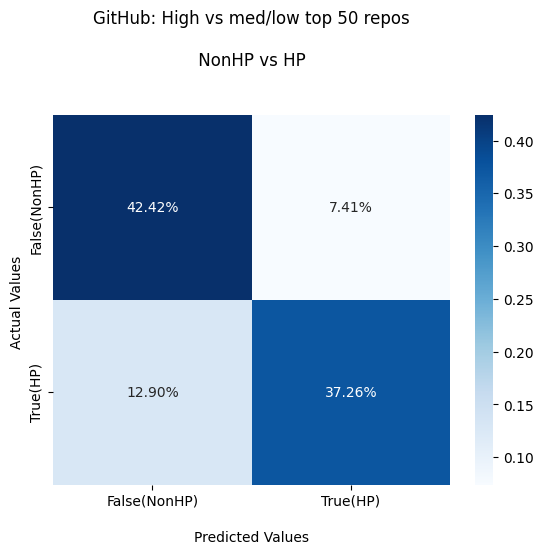

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: High vs med/low top 50 repos\n\n NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      3187
           1       0.83      0.74      0.79      3208

    accuracy                           0.80      6395
   macro avg       0.80      0.80      0.80      6395
weighted avg       0.80      0.80      0.80      6395



In [58]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.5974954673966821


In [59]:
tracker.stop()

0.0013301975262947688